# The Benefits of Kernel PCovR for the WHO Dataset

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

from skcosmo.preprocessing import StandardFlexibleScaler
from skcosmo.decomposition import PCovR, KernelPCovR

from scipy.stats import pearsonr

## Load the Dataset

In [2]:
df = pd.read_csv('data.csv', delimiter=',').dropna()
df

,Country,Year,SP.POP.TOTL,SH.TBS.INCD,SH.IMM.MEAS,SE.XPD.TOTL.GD.ZS,SH.DYN.AIDS.ZS,SP.DYN.LE00.IN,SH.IMM.IDPT,SH.XPD.CHEX.GD.ZS,SN.ITK.DEFC.ZS,NY.GDP.PCAP.CD
0,Afghanistan,2005,24411191.0,189.0,50.0,2.57000,0.1,58.361,58.0,9.948290,36.1,255.055120
1,Afghanistan,2006,25442944.0,189.0,53.0,2.90000,0.1,58.684,58.0,10.622766,33.3,274.000486
2,Afghanistan,2007,25903301.0,189.0,55.0,2.85000,0.1,59.111,63.0,9.904675,29.8,375.078128
3,Afghanistan,2008,26427199.0,189.0,59.0,3.51000,0.1,59.852,64.0,10.256495,26.5,387.849174
4,Afghanistan,2009,27385307.0,189.0,60.0,3.73000,0.1,60.364,63.0,9.818487,23.3,443.845151
...,...,...,...,...,...,...,...,...,...,...,...,...
2015,South Africa,2015,55876504.0,988.0,86.0,5.48285,18.2,63.950,85.0,8.790190,5.2,6204.929901
2016,South Africa,2016,56422274.0,805.0,84.0,5.44424,18.4,64.747,85.0,8.821429,5.4,5735.066787
2017,South Africa,2017,56641209.0,738.0,81.0,5.59867,18.5,65.402,84.0,8.722624,5.5,6734.475153
2018,South Africa,2018,57339635.0,677.0,81.0,5.64401,18.6,65.674,82.0,8.858297,5.7,7048.522211


In [3]:
columns = [
    "SP.POP.TOTL",
    "SH.TBS.INCD",
    "SH.IMM.MEAS",
    "SE.XPD.TOTL.GD.ZS",
    "SH.DYN.AIDS.ZS",
    "SH.IMM.IDPT",
    "SH.XPD.CHEX.GD.ZS",
    "SN.ITK.DEFC.ZS",
    "NY.GDP.PCAP.CD",
]

X_raw = np.array(df[columns])

# We are taking the logarithm of the population  and GDP to avoid extreme distributions
log_scaled = ["SP.POP.TOTL", "NY.GDP.PCAP.CD"]
for ls in log_scaled:
    print(X_raw[:, columns.index(ls)].min(), X_raw[:, columns.index(ls)].max())
    if ls in columns:
        X_raw[:, columns.index(ls)] = np.log10(X_raw[:, columns.index(ls)])
y_raw = np.array(df["SP.DYN.LE00.IN"])  # [np.where(df['Year']==2000)[0]])
y_raw = y_raw.reshape(-1, 1)
X_raw.shape

149841.0 7742681934.0
110.460874721483 123678.70214327476


(2020, 9)

### Scale and Center the Features and Targets

In [4]:
x_scaler = StandardFlexibleScaler(column_wise=True)
X = x_scaler.fit_transform(X_raw)

y_scaler = StandardFlexibleScaler(column_wise=True)
y = y_scaler.fit_transform(y_raw)

n_components = 2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

## Train the Different Linear DR Techniques

In [5]:
# Best Error for Linear Regression
RidgeCV(cv=5, alphas=np.logspace(-8,2, 20), fit_intercept=False).fit(X_train, y_train).score(X_test, y_test)

0.8649796774109517

### PCovR

0.821796939431064

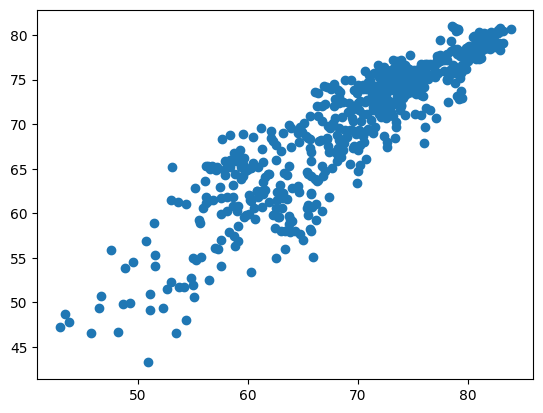

In [6]:
pcovr = PCovR(n_components=n_components, regressor=Ridge(alpha=1e-4, fit_intercept=False), mixing=0.5).fit(X_train, y_train)
T_train_pcovr = pcovr.transform(X_train)
T_test_pcovr = pcovr.transform(X_test)
T_pcovr = pcovr.transform(X)

r_pcovr = Ridge(alpha=1e-4, fit_intercept=False).fit(T_train_pcovr, y_train)
yp_pcovr = r_pcovr.predict(T_test_pcovr)

plt.scatter(y_scaler.inverse_transform(y_test), y_scaler.inverse_transform(yp_pcovr))
r_pcovr.score(T_test_pcovr, y_test)

### PCA

0.7923280928482219

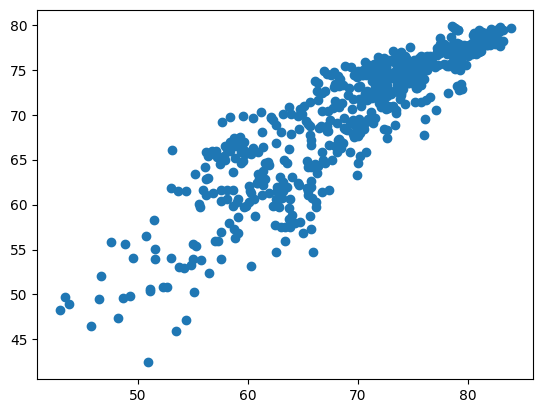

In [7]:
pca = PCA(
    n_components=n_components,
).fit(X_train, y_train)
T_train_pca = pca.transform(X_train)
T_test_pca = pca.transform(X_test)
T_pca = pca.transform(X)

r_pca = Ridge(alpha=1e-4, fit_intercept=False).fit(T_train_pca, y_train)
yp_pca = r_pca.predict(T_test_pca)

plt.scatter(y_scaler.inverse_transform(y_test), y_scaler.inverse_transform(yp_pca))
r_pca.score(T_test_pca, y_test)

In [8]:
for c, x in zip(columns, X.T):
    print(c, pearsonr(x, T_pca[:,0])[0], pearsonr(x, T_pca[:,1])[0])

SP.POP.TOTL 0.22826330289197194 -0.38181186469706535
SH.TBS.INCD 0.6122871683756762 0.6471847295285869
SH.IMM.MEAS -0.8528128883540281 0.09867916650668374
SE.XPD.TOTL.GD.ZS -0.41886383455352866 0.6062846443136231
SH.DYN.AIDS.ZS 0.309871862970166 0.8506795311066635
SH.IMM.IDPT -0.8528511229207462 0.12695070244132042
SH.XPD.CHEX.GD.ZS -0.4528598331864895 0.3025647054057431
SN.ITK.DEFC.ZS 0.8219689449524197 0.08159002381304771
NY.GDP.PCAP.CD -0.798743331495065 0.04866390274350206


## Train the Different Kernel DR Techniques

### Select Kernel Hyperparameters

In [9]:
param_grid = {"gamma": np.logspace(-8, 3, 20), "alpha": np.logspace(-8, 3, 20)}
clf = KernelRidge(kernel='rbf')

gs = GridSearchCV(estimator=clf, param_grid=param_grid)
gs.fit(X_train, y_train)
gs.best_estimator_

KernelRidge(alpha=0.0016237767391887243, gamma=0.08858667904100832,
            kernel='rbf')

In [10]:
# Best Error for Kernel Regression
gs.best_score_

0.9681443457289092

In [11]:
kernel_params = {"kernel": "rbf", "gamma": gs.best_estimator_.gamma}

### KPCovR

0.9716397791003146

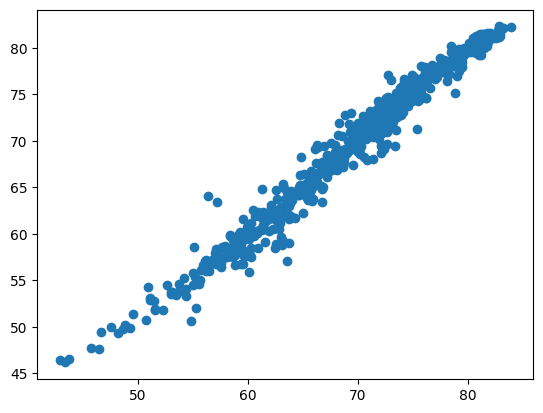

In [12]:
kpcovr = KernelPCovR(
    n_components=n_components,
    regressor=KernelRidge(alpha=gs.best_estimator_.alpha, **kernel_params),
    mixing=0.5,
    **kernel_params,
).fit(X_train, y_train)

T_train_kpcovr = kpcovr.transform(X_train)
T_test_kpcovr = kpcovr.transform(X_test)
T_kpcovr = kpcovr.transform(X)

r_kpcovr = KernelRidge(**kernel_params).fit(T_train_kpcovr, y_train)
yp_kpcovr = r_kpcovr.predict(T_test_kpcovr)

plt.scatter(y_scaler.inverse_transform(y_test), y_scaler.inverse_transform(yp_kpcovr))
r_kpcovr.score(T_test_kpcovr, y_test)

### KPCA

0.6748885851251916

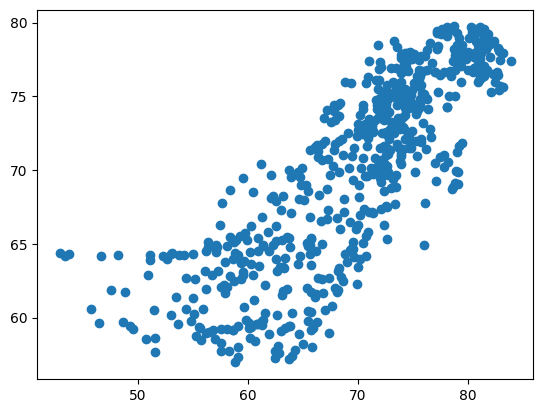

In [13]:
kpca = KernelPCA(
    n_components=n_components,
    **kernel_params,
).fit(X_train, y_train)

T_train_kpca = kpca.transform(X_train)
T_test_kpca = kpca.transform(X_test)
T_kpca = kpca.transform(X)

r_kpca = KernelRidge(**kernel_params).fit(T_train_kpca, y_train)
yp_kpca = r_kpca.predict(T_test_kpca)

plt.scatter(y_scaler.inverse_transform(y_test), y_scaler.inverse_transform(yp_kpca))
r_kpca.score(T_test_kpca, y_test)

### Correlation of the different variables with the KPCovR axes

In [14]:
for c, x in zip(columns, X.T):
    print(c, pearsonr(x, T_kpcovr[:,0])[0], pearsonr(x, T_kpcovr[:,1])[0])

SP.POP.TOTL 0.07407641494739012 0.05744806523399524
SH.TBS.INCD 0.6820418600365442 -0.03112471744468664
SH.IMM.MEAS -0.6630791472376114 0.01576075748073264
SE.XPD.TOTL.GD.ZS -0.23160844964887067 -0.38095411838878646
SH.DYN.AIDS.ZS 0.520468162873782 -0.10082174633994492
SH.IMM.IDPT -0.6456653256582803 0.022482030670449335
SH.XPD.CHEX.GD.ZS -0.38519993800097513 -0.5917512908058756
SN.ITK.DEFC.ZS 0.7301395863833018 0.07939643261813574
NY.GDP.PCAP.CD -0.8199857087901377 -0.5193579048930067


## Plot Our Results

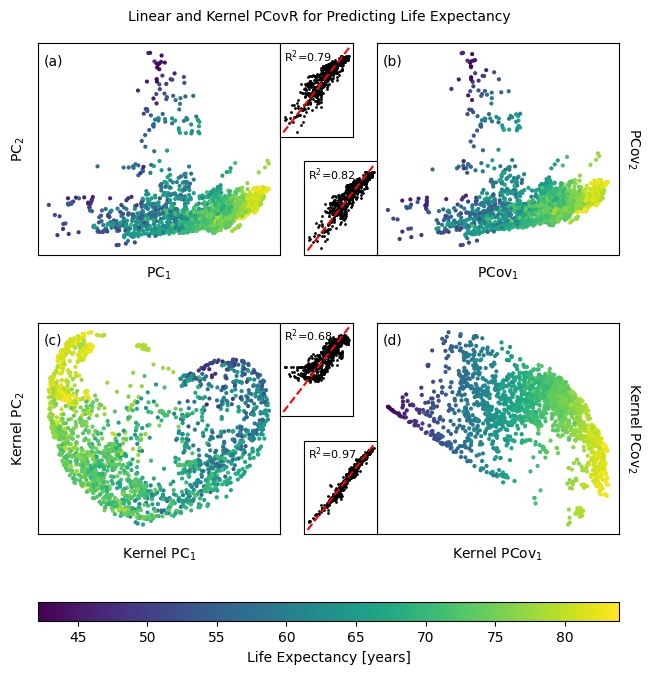

In [15]:
fig, axes = plt.subplot_mosaic(
    """
                                AFF.B
                                A.GGB
                                .....
                                CHH.D
                                C.IID
                                .....
                                EEEEE
                                """,
    figsize=(7.5, 7.5),
    gridspec_kw=dict(
        height_ratios=(0.5, 0.5, 0.1, 0.5, 0.5, 0.1, 0.1),
        width_ratios=(1, 0.1, 0.2, 0.1, 1),
    ),
)
axPCA, axPCovR, axKPCA, axKPCovR = axes["A"], axes["B"], axes["C"], axes["D"]
axPCAy, axPCovRy, axKPCAy, axKPCovRy = axes["F"], axes["G"], axes["H"], axes["I"]

def add_subplot(ax, axy, T, yp, let=''):
    p = ax.scatter(-T[:, 0], T[:, 1], c=y_raw, s=4)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.annotate(
        xy=(0.025, 0.95),
        xycoords="axes fraction",
        text=f"({let})",
        va='top',
        ha='left'
    )
    axy.scatter(
        y_scaler.inverse_transform(y_test),
        y_scaler.inverse_transform(yp),
        c="k",
        s=1,
    )
    axy.plot([y_raw.min(), y_raw.max()], [y_raw.min(), y_raw.max()], "r--")
    axy.annotate(
        xy=(0.05, 0.95),
        xycoords="axes fraction",
        text=r"R$^2$=%0.2f" % round(r2_score(y_test, yp), 3),
        va='top',
        ha='left',
        fontsize=8,
    )
    axy.set_xticks([])
    axy.set_yticks([])
    return p


p = add_subplot(axPCA, axPCAy, T_pca, yp_pca, 'a')
axPCA.set_xlabel("PC$_1$")
axPCA.set_ylabel("PC$_2$")

add_subplot(axPCovR, axPCovRy, T_pcovr @ np.diag([-1,1]), yp_pcovr, 'b')
axPCovR.yaxis.set_label_position("right")
axPCovR.set_xlabel("PCov$_1$")
axPCovR.set_ylabel("PCov$_2$", rotation=-90, va="bottom")

add_subplot(axKPCA, axKPCAy, T_kpca @ np.diag([-1,1]), yp_kpca, 'c')
axKPCA.set_xlabel("Kernel PC$_1$", fontsize=10)
axKPCA.set_ylabel("Kernel PC$_2$", fontsize=10)

add_subplot(axKPCovR, axKPCovRy, T_kpcovr, yp_kpcovr, 'd')
axKPCovR.yaxis.set_label_position("right")
axKPCovR.set_xlabel("Kernel PCov$_1$", fontsize=10)
axKPCovR.set_ylabel("Kernel PCov$_2$", rotation=-90, va="bottom", fontsize=10)

plt.colorbar(
    p, cax=axes["E"], label="Life Expectancy [years]", orientation="horizontal"
)
fig.subplots_adjust(wspace=0, hspace=0.4)
fig.suptitle("Linear and Kernel PCovR for Predicting Life Expectancy", y=0.925, fontsize=10)
plt.savefig('who.png', bbox_inches='tight', dpi=300)